In [1]:
import torch
from PIL import Image
from torchvision import transforms
import numpy as np
import torch.nn as nn
import os
import torch.optim as optim
import matplotlib.pyplot as plt
import cv2

# 预处理，缩放到一定大小，然后转换为张量tensor格式。
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
])

# 加载数据集Set12
dataset = 'D:/数据分析/数据集/Set12/'
image_files = os.listdir(dataset)

def add_poisson_noise(image, lam=10):
    """
    添加泊松噪声
    参数:
    image : 原始图像
    lam: 泊松分布参数, 越大噪声越大
    """
    # 将图像转化为浮点型并正则化到[0,1]
    img = np.array(image).astype(float) / 255
    
    # 添加泊松噪声
    vals = len(np.unique(img))
    vals = 2 ** np.ceil(np.log2(vals))
    img_noisy = np.random.poisson(img * vals) / float(vals)

    # 将值再限制到[0,1]之间
    img_noisy = np.clip(img_noisy, 0, 1)
   
    # 将浮点数组转成uint8，并恢复成[0,255]区间
    img_noisy = (255*img_noisy).astype(np.uint8)

    # 将ndarray转换回PIL Image并转化为RGB
    img_noisy = Image.fromarray(img_noisy).convert('RGB')

    return img_noisy

In [2]:
#均值滤波去噪
def remove_noise_with_mean_filter(image_noisy):
    """
    使用均值滤波器去噪
    参数:
    image_noisy_MF : 有噪声的图像
    image_denoised_MF : 均值滤波(MF)去噪后的图像
    """
    # 均值滤波器的大小，可以根据实际情况进行调整
    ksize = (3, 3)
    
    # 将PIL Image转换为ndarray
    image_noisy_np = np.array(image_noisy)
    
    # 使用cv2.blur进行均值滤波
    image_denoised_np = cv2.blur(image_noisy_np, ksize)
    
    # 将ndarray转换回PIL Image
    image_denoised_MF = Image.fromarray(image_denoised_np)
    
    return image_denoised_MF

# 测试一下
for i, image_file in enumerate(image_files):
    image = Image.open(os.path.join(dataset, image_file))
    image_noisy_MF = add_poisson_noise(image)
    image_denoised_MF = remove_noise_with_mean_filter(image_noisy_MF)
    # 保存去噪后的图像
    image_denoised_MF.save(f"D:/数据分析/数据集/Set12泊松噪声10/{image_file}")
    

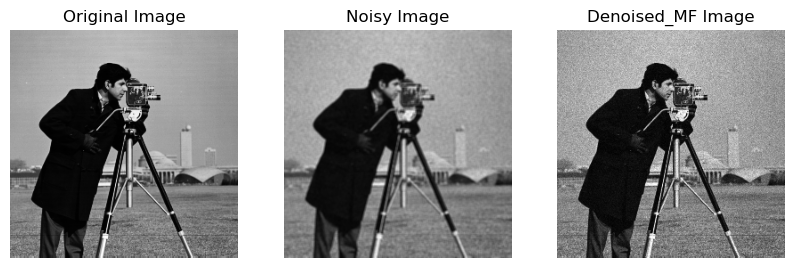

In [3]:
import matplotlib.pyplot as plt

def compare_images(image,image_noisy_MF, image_denoised_MF):
    """
    对比原图像和去噪后的图像
    参数:
    image ：原图像
    image_noisy_MF : 有噪声的图像
    image_denoised_MF : 均值滤波(MF)去噪后的图像
    """
    fig, axs = plt.subplots(1, 3, figsize=(10, 5))
    
    # 将图像转换为灰度图并显示
    axs[0].imshow(image, cmap='gray')
    axs[0].set_title('Original Image')

    axs[1].imshow(image_noisy_MF, cmap='gray')
    axs[1].set_title('Noisy Image')

    axs[2].imshow(image_denoised_MF, cmap='gray')
    axs[2].set_title('Denoised_MF Image')
    # 关闭坐标轴
    for ax in axs:
        ax.axis('off')

    plt.show()

# 测试一下：只显示第一张图
image_file = image_files[0]
image = Image.open(os.path.join(dataset, image_file))
image_noisy_MF = add_poisson_noise(image)
image_denoised_MF = remove_noise_with_mean_filter(image_noisy_MF)
compare_images(image, image_denoised_MF,image_noisy_MF)  # 对比原图像和去噪后的图像


In [4]:
class DnCNN(nn.Module):
    def __init__(self, channels, num_of_layers=17):
        super(DnCNN, self).__init__()
        kernel_size = 3
        padding = 1
        features = 64
        layers = []
        layers.append(nn.Conv2d(in_channels=channels, out_channels=features, kernel_size=kernel_size, padding=padding, bias=False))
        layers.append(nn.ReLU(inplace=True))
        for _ in range(num_of_layers-2):
            layers.append(nn.Conv2d(in_channels=features, out_channels=features, kernel_size=kernel_size, padding=padding, bias=False))
            layers.append(nn.BatchNorm2d(features))
            layers.append(nn.ReLU(inplace=True))
        layers.append(nn.Conv2d(in_channels=features, out_channels=channels, kernel_size=kernel_size, padding=padding, bias=False))
        self.dncnn = nn.Sequential(*layers)
    def forward(self, x):
        out = self.dncnn(x)
        return out


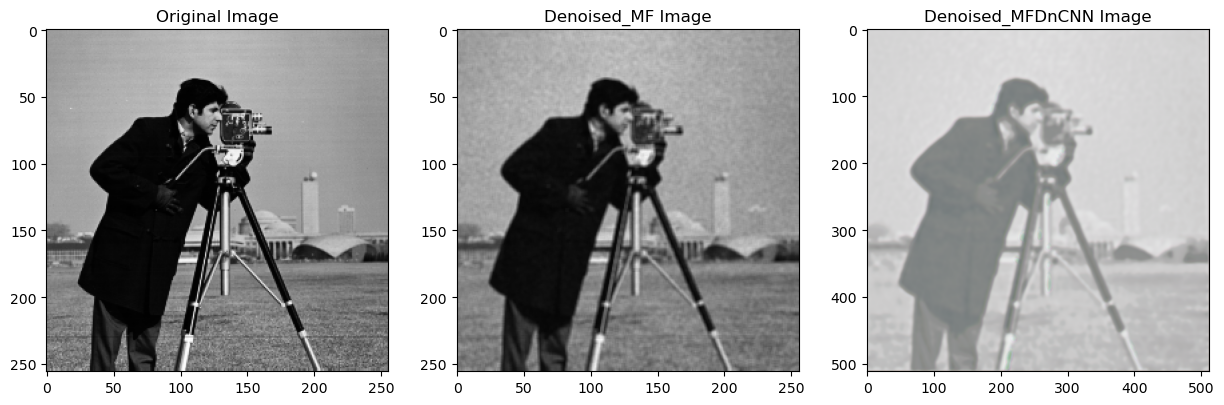

In [5]:
#泊松噪声lam10，MF去噪后再用DnCNN去噪
# 加载已经训练的DnCNN模型
dncnn_model = DnCNN(channels=3)
dncnn_model.load_state_dict(torch.load('D:/数据分析/数据集/model_MF_Adm.pth'))
dncnn_model.eval()

dataset_MF = "D:/数据分析/数据集/Set12泊松噪声10/"
# 从数据集中选择一张图片
image_path = os.path.join(dataset_MF, image_files[0])
image_MF = Image.open(image_path).convert('RGB')

# 用DnCNN模型去噪
noisy_image_tensor = transform(image_denoised_MF).unsqueeze(0)
with torch.no_grad():
    denoised_image_tensor = dncnn_model(noisy_image_tensor)
    """
    使用MF+DnCNN去噪
    参数:
    image_denoised_MFDnCNN : MF去噪后用DnCNN去噪后的图像
    """
# 将denoised_image_tensor从tensor转换回图像
image_denoised_MFDnCNN = denoised_image_tensor.squeeze(0).cpu().numpy().transpose(1, 2, 0)
image_denoised_MFDnCNN = (image_denoised_MFDnCNN * 0.5) + 0.5    # 缩放到 [0, 1] 范围
image_denoised_MFDnCNN = (image_denoised_MFDnCNN * 255).astype(np.uint8)

# 显示原始图像、带噪声图像和去噪后的图像
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(image,cmap='gray')
plt.title('Original Image')
plt.subplot(1, 3, 2)
plt.imshow(image_MF)
plt.title('Denoised_MF Image')
plt.subplot(1, 3, 3)
plt.imshow(image_denoised_MFDnCNN,cmap='gray')
plt.title('Denoised_MFDnCNN Image')
plt.show()


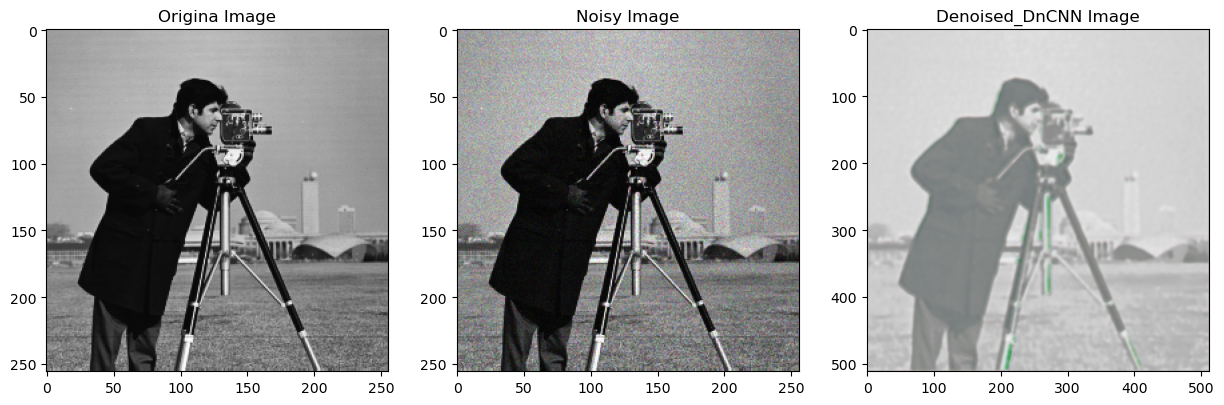

In [6]:
#泊松噪声lam10，直接用DnCNN去噪
# 加载已经训练的DnCNN模型
dncnn_model = DnCNN(channels=3)
dncnn_model.load_state_dict(torch.load('D:/数据分析/数据集/model_MF_Adm.pth'))
dncnn_model.eval()

# 从数据集中选择一张图片
image_path = os.path.join(dataset, image_files[0])
image = Image.open(image_path).convert('RGB')

# 添加泊松噪声
image_noisy_DnCNN = add_poisson_noise(image)

# 用DnCNN模型去噪
noisy_image_tensor = transform(image_noisy_DnCNN).unsqueeze(0)
with torch.no_grad():
    denoised_image_tensor = dncnn_model(noisy_image_tensor)
    """
    使用DnCNN去噪
    参数:
    image_noisy_DnCNN : 有噪声的图像
    image_denoised_DnCNN : 只用DnCNN去噪后的图像
    """
# 将denoised_image_tensor从tensor转换回图像
image_denoised_DnCNN = denoised_image_tensor.squeeze(0).cpu().numpy().transpose(1, 2, 0)
image_denoised_DnCNN = (image_denoised_DnCNN * 0.5) + 0.5    # 缩放到 [0, 1] 范围
image_denoised_DnCNN = (image_denoised_DnCNN * 255).astype(np.uint8)

# 显示原始图像、带噪声图像和去噪后的图像
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title('Origina Image')
plt.subplot(1, 3, 2)
plt.imshow(image_noisy_DnCNN,cmap='gray')
plt.title('Noisy Image')
plt.subplot(1, 3, 3)
plt.imshow(image_denoised_DnCNN,cmap='gray')
plt.title('Denoised_DnCNN Image')
plt.show()


In [7]:
from skimage.metrics import peak_signal_noise_ratio

# 先将原图像转为灰度图像
original_gray = cv2.cvtColor(np.asarray(image), cv2.COLOR_RGB2GRAY)

# 获取原图像的尺寸
image_shape =  original_gray.shape

# 将所有图像调整为原图像的大小
image_resized = cv2.resize(np.asarray(image), image_shape[::-1])
denoised_MFDnCNN_resized = cv2.resize(np.asarray(image_denoised_MFDnCNN), image_shape[::-1])
denoised_DnCNN_resized = cv2.resize(np.asarray(image_denoised_DnCNN), image_shape[::-1])
denoised_img_noisy_resized = cv2.resize(np.array(image_noisy_DnCNN), image_shape[1::-1])

# 再转换为灰度图像
denoised_MFDnCNN_gray = cv2.cvtColor(denoised_MFDnCNN_resized, cv2.COLOR_RGB2GRAY)
denoised_DnCNN_gray = cv2.cvtColor(denoised_DnCNN_resized, cv2.COLOR_RGB2GRAY)
denoised_img_noisy_gray = cv2.cvtColor(denoised_img_noisy_resized, cv2.COLOR_RGB2GRAY)

# 计算PSNR
psnr_MFDnCNN = peak_signal_noise_ratio(original_gray, denoised_MFDnCNN_gray)
psnr_DnCNN = peak_signal_noise_ratio(original_gray, denoised_DnCNN_gray)
psnr_img_noisy = peak_signal_noise_ratio(original_gray, denoised_img_noisy_gray)

print(f"MF+DnCNN PSNR: {psnr_MFDnCNN}")
print(f"DnCNN PSNR: {psnr_DnCNN}")
print(f"img_noisy PSNR: {psnr_img_noisy}")

MF+DnCNN PSNR: 10.411747426884308
DnCNN PSNR: 10.487045496984468
img_noisy PSNR: 30.81073705464288
